In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv(r'Walmart.csv')

In [13]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


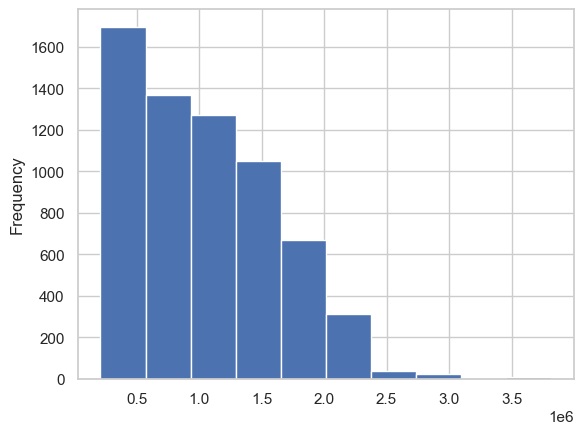

In [14]:
df['Weekly_Sales'].plot(kind='hist');

In [15]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Check for missing values and duplicates
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()

print("Missing values per column:")
print(missing_values)
print("\nNumber of duplicate rows:")
print(duplicates)


Missing values per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Number of duplicate rows:
0


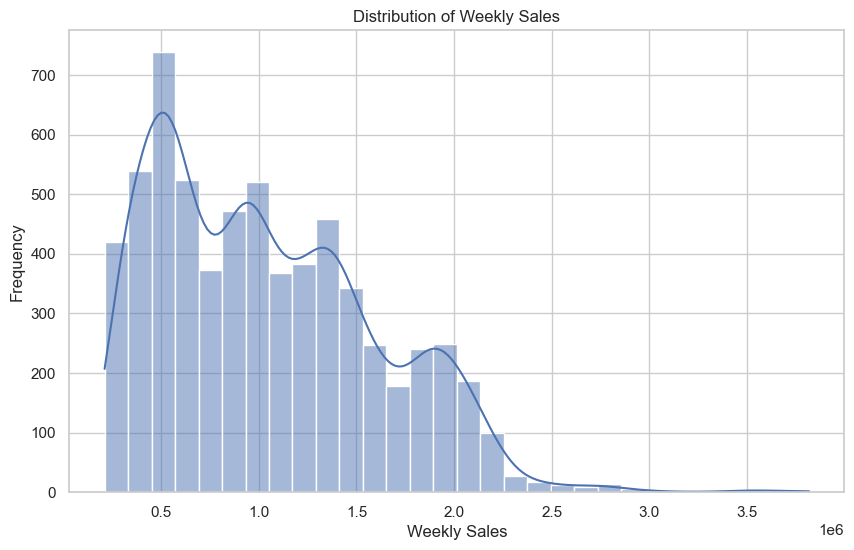

In [16]:
import seaborn as sns
# Set the style of the visualizations
sns.set_theme(style="whitegrid")

# Sales Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], bins=30, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

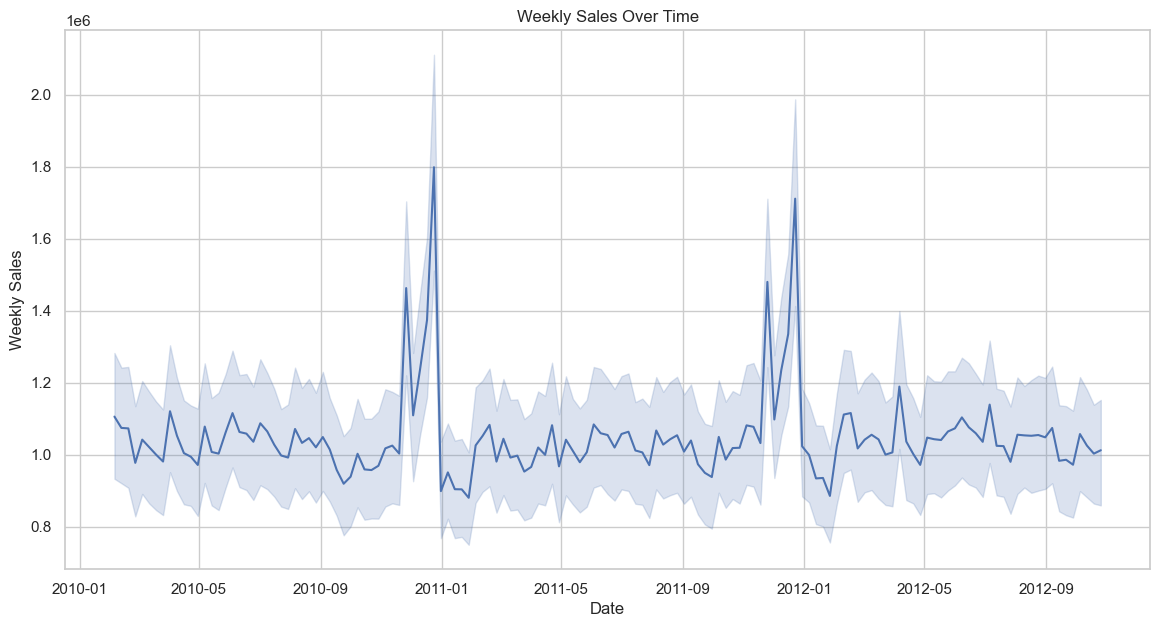

In [17]:

# Sales Trends Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

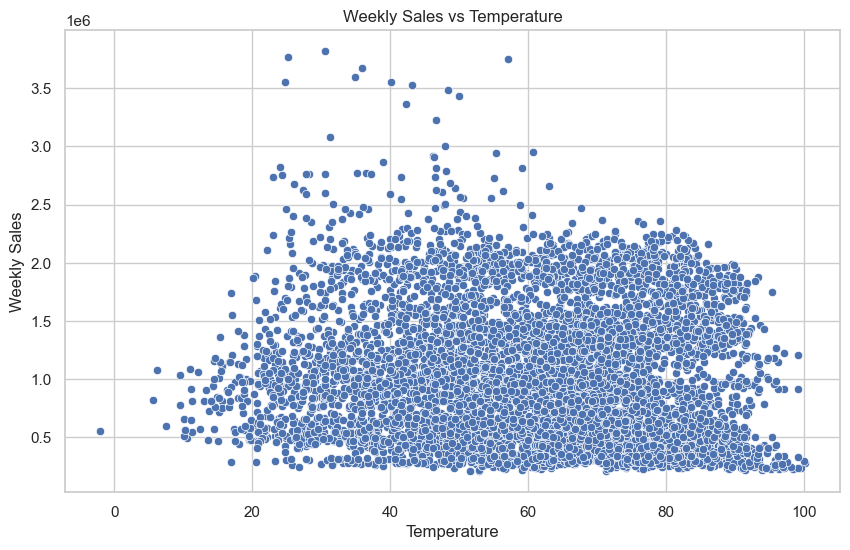

In [18]:
# Sales vs Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Temperature', y='Weekly_Sales')
plt.title('Weekly Sales vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

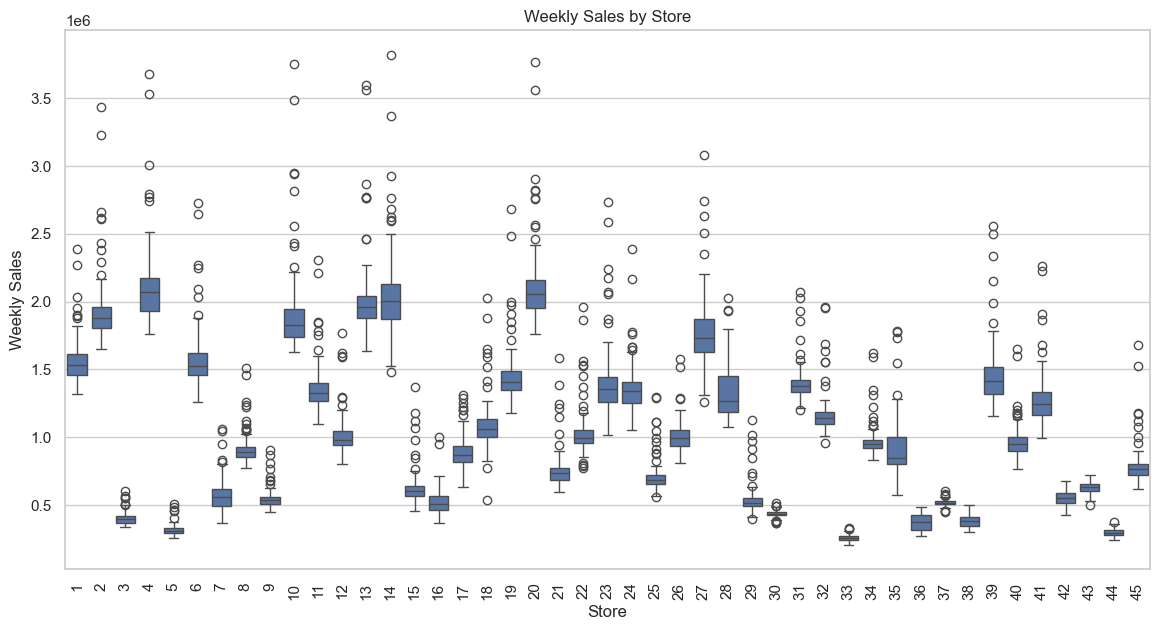

In [19]:
# Sales by Store
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Store', y='Weekly_Sales')
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=90)
plt.show()

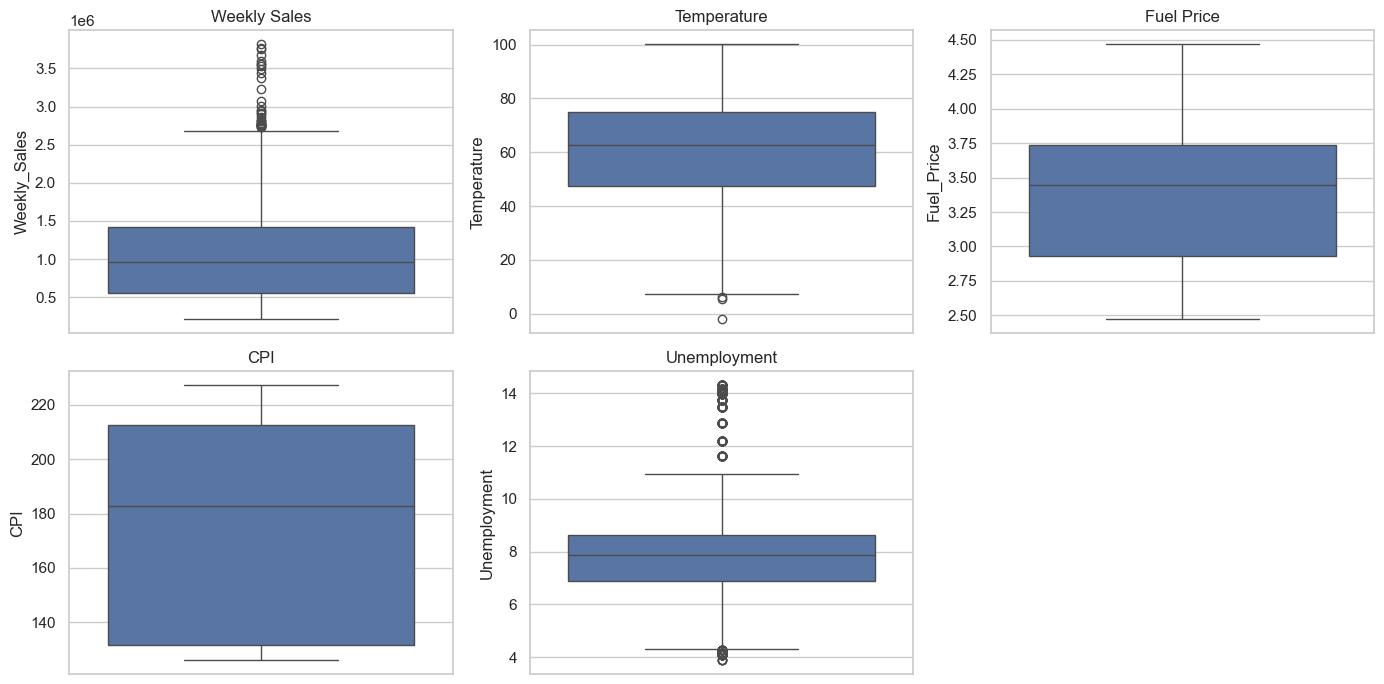

In [20]:
# Checking for outliers using box plots for relevant columns
plt.figure(figsize=(14, 7))
plt.subplot(2, 3, 1)
sns.boxplot(y=df['Weekly_Sales'])
plt.title('Weekly Sales')

plt.subplot(2, 3, 2)
sns.boxplot(y=df['Temperature'])
plt.title('Temperature')

plt.subplot(2, 3, 3)
sns.boxplot(y=df['Fuel_Price'])
plt.title('Fuel Price')

plt.subplot(2, 3, 4)
sns.boxplot(y=df['CPI'])
plt.title('CPI')

plt.subplot(2, 3, 5)
sns.boxplot(y=df['Unemployment'])
plt.title('Unemployment')

plt.tight_layout()
plt.show()

# Function to calculate outliers using IQR method
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Calculate outliers for each relevant column
weekly_sales_outliers = calculate_outliers(df['Weekly_Sales'])
temperature_outliers = calculate_outliers(df['Temperature'])
fuel_price_outliers = calculate_outliers(df['Fuel_Price'])
cpi_outliers = calculate_outliers(df['CPI'])
unemployment_outliers = calculate_outliers(df['Unemployment'])

# Summary of outliers
outliers_summary = {
    'Weekly_Sales_Outliers': weekly_sales_outliers,
    'Temperature_Outliers': temperature_outliers,
    'Fuel_Price_Outliers': fuel_price_outliers,
    'CPI_Outliers': cpi_outliers,
    'Unemployment_Outliers': unemployment_outliers
}



In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Sort the dataframe by date
df.sort_values('Date', inplace=True)

# Set the date as the index
df.set_index('Date', inplace=True)

# Resampling the data by week
weekly_data = df['Weekly_Sales'].resample('W').sum()

# Function to create training and test datasets
def create_train_test_split(data, train_size=0.8):
    train_len = int(len(data) * train_size)
    train_data = data[:train_len]
    test_data = data[train_len:]
    return train_data, test_data

# Train-test split
train_data, test_data = create_train_test_split(weekly_data)

# Preprocessing for LSTM
def preprocess_lstm(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(weekly_data.values.reshape(-1, 1))

# Prepare the data for LSTM
time_step = 4
X_train, y_train = preprocess_lstm(scaled_data[:len(train_data)], time_step)
X_test, y_test = preprocess_lstm(scaled_data[len(train_data):], time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [28]:

# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predicting
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test, test_predict[:,0]))

print(f'LSTM Train Score: {train_score:.2f} RMSE')
print(f'LSTM Test Score: {test_score:.2f} RMSE')

# Forecasting with ARIMA
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test_data))

# Calculate RMSE for ARIMA
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print(f'ARIMA Test Score: {arima_rmse:.2f} RMSE')

# Forecasting with Prophet
prophet_df = weekly_data.reset_index().rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df.iloc[:len(train_data)])
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
prophet_forecast = prophet_model.predict(future)

# Calculate RMSE for Prophet
prophet_rmse = np.sqrt(mean_squared_error(test_data, prophet_forecast['yhat'].iloc[-len(test_data):]))
print(f'Prophet Test Score: {prophet_rmse:.2f} RMSE')

# Plotting the results
plt.figure(figsize=(14, 7))

# LSTM Predictions
plt.plot(weekly_data.index, weekly_data.values, label='True Values')
plt.plot(weekly_data.index[time_step:len(train_predict) + time_step], train_predict, label='LSTM Train Predictions')
plt.plot(weekly_data.index[len(train_predict) + time_step:], test_predict, label='LSTM Test Predictions')

# ARIMA Predictions
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast')

# Prophet Predictions
plt.plot(test_data.index, prophet_forecast['yhat'].iloc[-len(test_data):], label='Prophet Forecast')

plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

import ace_tools as tools; tools.display_dataframe_to_user(name="Outliers Summary", dataframe=pd.DataFrame(outliers_summary))

c:\Users\Spandana\miniconda3\envs\milu\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: object __array__ method not producing an array